# What is Persistence?

## Concept of Graph

A **Graph** in LangGraph is a computational workflow composed of:
- **Nodes**: Functions that perform operations (e.g., LLM calls, data processing)
- **Edges**: Connections that define execution flow between nodes
- **State**: Shared data structure that flows through the graph

```
     Node A
       ↓
    (Edge)
       ↓
     Node B  ← State flows through
       ↓
    (Edge)
       ↓
     Node C
```

## Concept of State

**State** is a shared data structure that:
- Stores variables/keys accessible to all nodes
- Gets passed along edges from node to node
- Can be read and modified by any node during execution
- Represents the current context of the graph execution

```python
# Example State
class GraphState(TypedDict):
    messages: list
    user_input: str
    result: str
```

Each node receives the current state, processes it, and returns updates.

## Concept of Persistence

**Persistence** enables saving and restoring graph state across executions. This provides:

1. **State Preservation**: Store the complete state after each node execution
2. **Conversation Memory**: Resume multi-turn conversations from where you left off
3. **Fault Tolerance**: Recover from crashes without losing progress
4. **Time Travel**: Access any previous checkpoint in execution history
5. **Debugging**: Inspect intermediate states for troubleshooting

```
Without Persistence:     With Persistence:
Run 1 → Lost ❌          Run 1 → Saved ✓
Run 2 → Start over       Run 2 → Continue from Run 1
```

## Checkpoint and Checkpointer

**Checkpoint**: A snapshot of the graph state at a specific point in execution
- Contains the complete state after a node finishes
- Includes metadata (timestamp, node name, thread_id)
- Allows rollback to any previous state

**Checkpointer**: The mechanism that manages checkpoint storage and retrieval

```python
# Common Checkpointers:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver

# In-memory (temporary)
memory = MemorySaver()

# Persistent database
checkpointer = SqliteSaver.from_conn_string("checkpoints.db")

# Attach to graph
graph = graph.compile(checkpointer=memory)
```

**How it works:**
```
Node Execution → Create Checkpoint → Store in Checkpointer
                       ↓
                 {state, metadata}
                       ↓
              Memory/SQLite/Postgres
```

**Thread ID**: Used to organize checkpoints by conversation/session
```python
config = {"configurable": {"thread_id": "conversation_1"}}
graph.invoke(input, config=config)  # Saves to thread_id
```

## Threads in Persistence

**Thread** is a unique identifier that isolates conversation sessions or execution contexts. Each thread maintains its own independent checkpoint history.

#### Single Thread Flow
```
Thread: "user_123"
┌─────────────────────────────────────┐
│  Checkpoint 1: Initial state        │
│  Checkpoint 2: After Node A         │
│  Checkpoint 3: After Node B         │
│  Checkpoint 4: Final state          │
└─────────────────────────────────────┘
```

#### Multiple Threads (Isolated Sessions)
```
Thread: "user_123"          Thread: "user_456"          Thread: "user_789"
┌──────────────────┐        ┌──────────────────┐        ┌──────────────────┐
│ Checkpoint 1     │        │ Checkpoint 1     │        │ Checkpoint 1     │
│ Checkpoint 2     │        │ Checkpoint 2     │        │ Checkpoint 2     │
│ Checkpoint 3     │        │ Checkpoint 3     │        │ Checkpoint 3     │
└──────────────────┘        └──────────────────┘        └──────────────────┘
     ↓                           ↓                           ↓
Independent history        Independent history        Independent history
```

#### Thread Usage Example
```python
# User 1's conversation
config_user1 = {"configurable": {"thread_id": "user_123"}}
graph.invoke({"input": "Hello"}, config=config_user1)
graph.invoke({"input": "How are you?"}, config=config_user1)  # Continues from previous

# User 2's conversation (completely separate)
config_user2 = {"configurable": {"thread_id": "user_456"}}
graph.invoke({"input": "Hi there"}, config=config_user2)  # Fresh start
```

#### Thread Lifecycle
```
┌─────────────┐
│ New Thread  │
│ thread_id=1 │
└──────┬──────┘
       │
       v
┌─────────────┐     ┌──────────────┐
│ Invoke #1   │────>│ Checkpoint 1 │
└──────┬──────┘     └──────────────┘
       │
       v
┌─────────────┐     ┌──────────────┐
│ Invoke #2   │────>│ Checkpoint 2 │  <- Loads Checkpoint 1 first
└──────┬──────┘     └──────────────┘
       │
       v
┌─────────────┐     ┌──────────────┐
│ Invoke #3   │────>│ Checkpoint 3 │  <- Loads Checkpoint 2 first
└─────────────┘     └──────────────┘
```

#### Key Benefits of Threads
1. **Isolation**: Each user/session has independent state
2. **Concurrency**: Multiple threads can run simultaneously
3. **Context Preservation**: Maintains conversation history per thread
4. **Scalability**: Handle thousands of concurrent conversations
5. **Debugging**: Trace specific user sessions independently

## Workflow Diagrams

### Without Persistence
```
Execution 1:                    Execution 2:
┌─────────┐                     ┌─────────┐
│ Start   │                     │ Start   │
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐                     ┌─────────┐
│ Node A  │                     │ Node A  │
│ State={}│                     │ State={}│  <- State resets!
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐                     ┌─────────┐
│ Node B  │                     │ Node B  │
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐                     ┌─────────┐
│  End    │                     │  End    │
└─────────┘                     └─────────┘
State Lost ❌                   No History ❌
```

### With Persistence (Checkpointing)
```
Execution 1:                    Execution 2:
┌─────────┐                     ┌─────────┐
│ Start   │                     │ Start   │
└────┬────┘                     └────┬────┘
     │                               │
     v                               v
┌─────────┐    ┌──────────┐    ┌─────────┐
│ Node A  │───>│Checkpoint│    │ Node A  │
│State={a}│    │  Save    │    │State={a}│  <- State restored!
└────┬────┘    └──────────┘    └────┬────┘
     │              │                │
     v              v                v
┌─────────┐    ┌──────────┐    ┌─────────┐
│ Node B  │───>│Checkpoint│    │ Node B  │
│State={b}│    │  Save    │    │State={b}│  <- Continues from last!
└────┬────┘    └──────────┘    └────┬────┘
     │              │                │
     v              v                v
┌─────────┐    ┌──────────┐    ┌─────────┐
│  End    │    │ Storage  │    │  End    │
└─────────┘    └──────────┘    └─────────┘
State Saved ✓   Persistent ✓   History ✓
```

### Persistence Flow with Memory
```
┌──────────────────────────────────────────────┐
│           LangGraph Application              │
└──────────────────┬───────────────────────────┘
                   │
                   v
         ┌─────────────────┐
         │  Graph Executor │
         └────────┬────────┘
                  │
      ┌───────────┼───────────┐
      │           │           │
      v           v           v
  ┌───────┐  ┌───────┐  ┌───────┐
  │Node 1 │  │Node 2 │  │Node 3 │
  └───┬───┘  └───┬───┘  └───┬───┘
      │          │          │
      └──────────┼──────────┘
                 │
                 v
      ┌──────────────────────┐
      │   Checkpointer       │
      │  (MemorySaver/DB)    │
      └──────────┬───────────┘
                 │
                 v
      ┌──────────────────────┐
      │  Persistent Storage  │
      │  • State snapshots   │
      │  • Thread history    │
      │  • Conversation data │
      └──────────────────────┘
```

## Key Benefits of Persistence

1. **Resume Conversations**: Continue from where you left off
2. **Fault Tolerance**: Recover from failures without losing progress
3. **Time Travel**: Access any previous state in the execution history
4. **Multi-turn Interactions**: Maintain context across multiple invocations
5. **Debugging**: Inspect intermediate states for troubleshooting

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Creating the State for Graph using Class
class JokeState(TypedDict):
    topic : str
    joke : str
    explanation: str

In [3]:
model = init_chat_model("gpt-5-nano")
model

ChatOpenAI(profile={'max_input_tokens': 272000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7fcd6e64fe60>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7fcd6df10d10>, root_client=<openai.OpenAI object at 0x7fcd6e9a38c0>, root_async_client=<openai.AsyncOpenAI object at 0x7fcd6e64ff80>, model_name='gpt-5-nano', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [4]:
# Creating the function to generate joke
def generate_joke(state: JokeState):

    prompt = f"Generate a joke on the topic of {state['topic']}"

    joke = model.invoke(prompt).content

    return { "joke" : joke }

In [5]:
# Creating the function to generate joke
def generate_explanation(state: JokeState):

    prompt = f"Generate explanation of the joke {state['joke']}"

    explanation = model.invoke(prompt).content

    return { "explanation" : explanation }

In [6]:
# Let's Create the Graph
chat_graph = StateGraph(JokeState)

# Adding Nodes
chat_graph.add_node('generate_joke', generate_joke)
chat_graph.add_node('generate_explanation', generate_explanation)

# Adding Edges
chat_graph.add_edge(START, 'generate_joke')
chat_graph.add_edge('generate_joke', 'generate_explanation')
chat_graph.add_edge('generate_explanation', END)

# CheckPointer System to Store the State
checkpointer = InMemorySaver()

# Compiling the Graph
chat_workflow = chat_graph.compile(checkpointer=checkpointer)

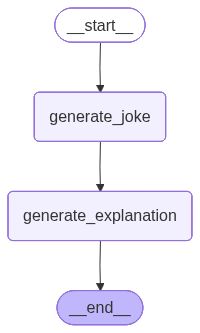

In [7]:
chat_workflow

In [8]:
initial_state = {
    "topic" : "GenAI Progress in India"
}

In [9]:
config_1 = { "configurable" : { "thread_id" : "1" } }

final_state = chat_workflow.invoke( initial_state, config = config_1 )

final_state

{'topic': 'GenAI Progress in India',
 'joke': 'Here are a few light jokes about GenAI progress in India. Pick your favorite or I can tailor one:\n\n- GenAI progress in India is so fast that my phone’s AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, “I need a job.”\n\n- In India, GenAI is moving so quickly that the chaiwala’s app can predict your spice tolerance, suggest the perfect chutney, and route the delivery—all while you take a sip.\n\n- GenAI in India is progressing so fast that even the dabbawala network uses AI to optimize lunchbox routes—bells ring, lunch lands, and you get a Hinglish update before the rotis cool.',
 'explanation': 'Here’s what each joke is playing with, in plain terms:\n\n- Joke 1: “GenAI progress… my phone’s AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, ‘I need a job.’”\n  - Why it’s funny: Exaggerates AI’s speed and autonomy. It starts with a relatable s

In [10]:
chat_workflow.get_state(config_1)

StateSnapshot(values={'topic': 'GenAI Progress in India', 'joke': 'Here are a few light jokes about GenAI progress in India. Pick your favorite or I can tailor one:\n\n- GenAI progress in India is so fast that my phone’s AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, “I need a job.”\n\n- In India, GenAI is moving so quickly that the chaiwala’s app can predict your spice tolerance, suggest the perfect chutney, and route the delivery—all while you take a sip.\n\n- GenAI in India is progressing so fast that even the dabbawala network uses AI to optimize lunchbox routes—bells ring, lunch lands, and you get a Hinglish update before the rotis cool.', 'explanation': 'Here’s what each joke is playing with, in plain terms:\n\n- Joke 1: “GenAI progress… my phone’s AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, ‘I need a job.’”\n  - Why it’s funny: Exaggerates AI’s speed and autonomy. It starts

In [11]:
from rich import print as rprint
import json

rprint(chat_workflow.get_state(config_1))

StateSnapshot(
    values={
        'topic': 'GenAI Progress in India',
        'joke': 'Here are a few light jokes about GenAI progress in India. Pick your favorite or I can tailor 
one:\n\n- GenAI progress in India is so fast that my phone’s AI wrote my resume, pitched it to investors, and 
booked me a job—all before I could finish saying, “I need a job.”\n\n- In India, GenAI is moving so quickly that 
the chaiwala’s app can predict your spice tolerance, suggest the perfect chutney, and route the delivery—all while 
you take a sip.\n\n- GenAI in India is progressing so fast that even the dabbawala network uses AI to optimize 
lunchbox routes—bells ring, lunch lands, and you get a Hinglish update before the rotis cool.',
        'explanation': 'Here’s what each joke is playing with, in plain terms:\n\n- Joke 1: “GenAI progress… my 
phone’s AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, ‘I need 
a job.’”\n  - Why it’s funny: Exaggerates AI’s speed and autonomy. It starts with a relatable situation (job 
hunting) and flips it so AI does everything instantly, even making the pitch and securing a job before you can 
finish a simple sentence. It ascribes almost magical efficiency to GenAI in a bite-sized, self-referential 
moment.\n\n- Joke 2: “In India, GenAI is moving so quickly that the chaiwala’s app can predict your spice 
tolerance, suggest the perfect chutney, and route the delivery—all while you take a sip.”\n  - Why it’s funny: 
Mixes a beloved everyday figure (chaiwala) with cutting-edge tech. The humor comes from AI handling tiny, everyday 
preferences (spice level, chutney choice) and logistics (routing) in real time—so fast you barely finish your tea. 
It playfully elevates a humble street-side vendor into a high-tech entrepeneur.\n\n- Joke 3: “GenAI in India is 
progressing so fast that even the dabbawala network uses AI to optimize lunchbox routes—bells ring, lunch lands, 
and you get a Hinglish update before the rotis cool.”\n  - Why it’s funny: Combines legendary efficiency (dabbawala
lunchbox system) with modern AI optimization. The image of bells signaling punctual delivery plus an AI-generated 
Hinglish update creates a vivid, cultural contrast. The line about rotis cooling adds a dash of timing-comedy—AI is
so fast you’re getting updates before the food cools.\n\nIf you’d like, I can tailor one of these (or craft a fresh
variant) for a specific audience, city, or tone. Do you prefer a version focused on work life, food culture, or a 
broader tech satire vibe?'
    },
    next=(),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50f9-a0b2-6ccb-8002-65fb64aa679a'
        }
    },
    metadata={'source': 'loop', 'step': 2, 'parents': {}},
    created_at='2026-01-19T08:19:40.622340+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50f8-da0e-6a0b-8001-30022798b4ee'
        }
    },
    tasks=(),
    interrupts=()
)

In [12]:
state_history = list(chat_workflow.get_state_history(config_1))

rprint(state_history)

[
    StateSnapshot(
        values={
            'topic': 'GenAI Progress in India',
            'joke': 'Here are a few light jokes about GenAI progress in India. Pick your favorite or I can tailor 
one:\n\n- GenAI progress in India is so fast that my phone’s AI wrote my resume, pitched it to investors, and 
booked me a job—all before I could finish saying, “I need a job.”\n\n- In India, GenAI is moving so quickly that 
the chaiwala’s app can predict your spice tolerance, suggest the perfect chutney, and route the delivery—all while 
you take a sip.\n\n- GenAI in India is progressing so fast that even the dabbawala network uses AI to optimize 
lunchbox routes—bells ring, lunch lands, and you get a Hinglish update before the rotis cool.',
            'explanation': 'Here’s what each joke is playing with, in plain terms:\n\n- Joke 1: “GenAI progress… my
phone’s AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, ‘I need 
a job.’”\n  - Why it’s funny: Exaggerates AI’s speed and autonomy. It starts with a relatable situation (job 
hunting) and flips it so AI does everything instantly, even making the pitch and securing a job before you can 
finish a simple sentence. It ascribes almost magical efficiency to GenAI in a bite-sized, self-referential 
moment.\n\n- Joke 2: “In India, GenAI is moving so quickly that the chaiwala’s app can predict your spice 
tolerance, suggest the perfect chutney, and route the delivery—all while you take a sip.”\n  - Why it’s funny: 
Mixes a beloved everyday figure (chaiwala) with cutting-edge tech. The humor comes from AI handling tiny, everyday 
preferences (spice level, chutney choice) and logistics (routing) in real time—so fast you barely finish your tea. 
It playfully elevates a humble street-side vendor into a high-tech entrepeneur.\n\n- Joke 3: “GenAI in India is 
progressing so fast that even the dabbawala network uses AI to optimize lunchbox routes—bells ring, lunch lands, 
and you get a Hinglish update before the rotis cool.”\n  - Why it’s funny: Combines legendary efficiency (dabbawala
lunchbox system) with modern AI optimization. The image of bells signaling punctual delivery plus an AI-generated 
Hinglish update creates a vivid, cultural contrast. The line about rotis cooling adds a dash of timing-comedy—AI is
so fast you’re getting updates before the food cools.\n\nIf you’d like, I can tailor one of these (or craft a fresh
variant) for a specific audience, city, or tone. Do you prefer a version focused on work life, food culture, or a 
broader tech satire vibe?'
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50f9-a0b2-6ccb-8002-65fb64aa679a'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T08:19:40.622340+00:00',
        parent_config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50f8-da0e-6a0b-8001-30022798b4ee'
            }
        },
        tasks=(),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'GenAI Progress in India',
            'joke': 'Here are a few light jokes about GenAI progress in India. Pick your favorite or I can tailor 
one:\n\n- GenAI progress in India is so fast that my phone’s AI wrote my resume, pitched it to investors, and 
booked me a job—all before I could finish saying, “I need a job.”\n\n- In India, GenAI is moving so quickly that 
the chaiwala’s app can predict your spice tolerance, suggest the perfect chutney, and route the delivery—all while 
you take a sip.\n\n- GenAI in India is progressing so fast that even the dabbawala network uses AI to optimize 
lunchbox routes—bells ring, lunch lands, and you get a Hinglish update before the rotis cool.'
        },
        next=('ge

In [13]:
# Now testing with a different thread
initial_state_thread_2 = {
    "topic" : "Critical - GenAI Progress in India"
}

config_2 = { "configurable" : { "thread_id": "2" } }

final_state_thread_2 = chat_workflow.invoke(initial_state_thread_2, config = config_2)

In [14]:
final_state_thread_2

{'topic': 'Critical - GenAI Progress in India',
 'joke': 'GenAI progress in India is so critical that the AI runs on chai, and its code comments are written in Hinglish: “Boss, deploy karna hai ya chai peeni hai?”',
 'explanation': 'Here’s a clear explanation of the joke and why it lands:\n\n- What the joke is saying\n  - It jokingly exaggerates that GenAI progress in India is so important that it “runs on chai” (tea) rather than electricity or GPUs, i.e., tea fuels the work.\n  - The code comments are shown in Hinglish (a mix of Hindi and English) as if Indian developers write their code with casual, bilingual notes.\n  - The Hinglish line “Boss, deploy karna hai ya chai peeni hai?” translates to “Boss, should we deploy or should we drink tea?” – a playful way to express a trivial, everyday dilemma during intense work.\n\n- Translation of the Hinglish line\n  - Boss = addressing the supervisor or team lead\n  - deploy karna hai = “we need to deploy”\n  - ya = or\n  - chai peeni hai = 

In [15]:
state_thread_2 = chat_workflow.get_state(config_2)

In [16]:
rprint(state_thread_2)

StateSnapshot(
    values={
        'topic': 'Critical - GenAI Progress in India',
        'joke': 'GenAI progress in India is so critical that the AI runs on chai, and its code comments are written
in Hinglish: “Boss, deploy karna hai ya chai peeni hai?”',
        'explanation': 'Here’s a clear explanation of the joke and why it lands:\n\n- What the joke is saying\n  - 
It jokingly exaggerates that GenAI progress in India is so important that it “runs on chai” (tea) rather than 
electricity or GPUs, i.e., tea fuels the work.\n  - The code comments are shown in Hinglish (a mix of Hindi and 
English) as if Indian developers write their code with casual, bilingual notes.\n  - The Hinglish line “Boss, 
deploy karna hai ya chai peeni hai?” translates to “Boss, should we deploy or should we drink tea?” – a playful way
to express a trivial, everyday dilemma during intense work.\n\n- Translation of the Hinglish line\n  - Boss = 
addressing the supervisor or team lead\n  - deploy karna hai = “we need to deploy”\n  - ya = or\n  - chai peeni hai
= “we need to drink tea”\n  - So the line means: “Do we deploy now, or do we drink tea?”\n\n- Why it’s funny\n  - 
Hyperbole: Claiming GenAI progress in India runs on chai is an exaggerated, humorous boast about tea being the fuel
for productivity.\n  - Juxtaposition: Serious, high-tech work (deploying AI) contrasted with a mundane, universally
relatable ritual (drinking chai).\n  - Language play: The mix of English (deploy) and Hindi (chai peeni, boss) 
mirrors everyday Indian workplace speech, which many find relatable and funny.\n  - Meta humor about comments: Code
comments are normally technical and utilitarian; turning them into a Hinglish office banter line adds a playful, 
human touch to a developer’s life.\n\n- Cultural context that boosts the joke\n  - Chai culture: Tea is integral to
daily life in India, often seen as a social fuel and a quick energy boost.\n  - Hinglish in tech culture: Many 
Indian developers naturally switch between languages, making Hinglish comments feel authentic and funny.\n  - 
Office dynamics: “Boss” as a casual, friendly term reflects common workplace hierarchies where such light banter 
can occur.\n\n- Potential sensitivities\n  - It relies on light stereotypes (chai as essential and Hinglish as 
common in Indian tech culture). It’s intended as affectionate humor, not a broad generalization about all Indian 
people or engineers.\n\n- Quick variants you might enjoy\n  - “Boss, deploy karna hai ya chai peeni hai?” (the 
original)\n  - “Boss, rollback karna hai ya chai peeni hai?”\n  - “Boss, file clean karna hai ya chai peeni hai?”\n
- Each keeps the same vibe by swapping the task with another common DevOps or coding moment.\n\nIf you’d like, I 
can tailor an explanation for a specific audience (engineers, non-tech readers, or students) or translate/expand it
into a short caption or a slide note.'
    },
    next=(),
    config={
        'configurable': {
            'thread_id': '2',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50fb-0ce7-6e22-8002-dc4696451fab'
        }
    },
    metadata={'source': 'loop', 'step': 2, 'parents': {}},
    created_at='2026-01-19T08:20:18.812249+00:00',
    parent_config={
        'configurable': {
            'thread_id': '2',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0f50fa-64d6-6cf4-8001-d3448ca982f3'
        }
    },
    tasks=(),
    interrupts=()
)

In [17]:
state_history_thread_2 = list(chat_workflow.get_state_history(config_2))

In [18]:
rprint(state_history_thread_2)

[
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is so critical that the AI runs on chai, and its code comments are 
written in Hinglish: “Boss, deploy karna hai ya chai peeni hai?”',
            'explanation': 'Here’s a clear explanation of the joke and why it lands:\n\n- What the joke is saying\n
- It jokingly exaggerates that GenAI progress in India is so important that it “runs on chai” (tea) rather than 
electricity or GPUs, i.e., tea fuels the work.\n  - The code comments are shown in Hinglish (a mix of Hindi and 
English) as if Indian developers write their code with casual, bilingual notes.\n  - The Hinglish line “Boss, 
deploy karna hai ya chai peeni hai?” translates to “Boss, should we deploy or should we drink tea?” – a playful way
to express a trivial, everyday dilemma during intense work.\n\n- Translation of the Hinglish line\n  - Boss = 
addressing the supervisor or team lead\n  - deploy karna hai = “we need to deploy”\n  - ya = or\n  - chai peeni hai
= “we need to drink tea”\n  - So the line means: “Do we deploy now, or do we drink tea?”\n\n- Why it’s funny\n  - 
Hyperbole: Claiming GenAI progress in India runs on chai is an exaggerated, humorous boast about tea being the fuel
for productivity.\n  - Juxtaposition: Serious, high-tech work (deploying AI) contrasted with a mundane, universally
relatable ritual (drinking chai).\n  - Language play: The mix of English (deploy) and Hindi (chai peeni, boss) 
mirrors everyday Indian workplace speech, which many find relatable and funny.\n  - Meta humor about comments: Code
comments are normally technical and utilitarian; turning them into a Hinglish office banter line adds a playful, 
human touch to a developer’s life.\n\n- Cultural context that boosts the joke\n  - Chai culture: Tea is integral to
daily life in India, often seen as a social fuel and a quick energy boost.\n  - Hinglish in tech culture: Many 
Indian developers naturally switch between languages, making Hinglish comments feel authentic and funny.\n  - 
Office dynamics: “Boss” as a casual, friendly term reflects common workplace hierarchies where such light banter 
can occur.\n\n- Potential sensitivities\n  - It relies on light stereotypes (chai as essential and Hinglish as 
common in Indian tech culture). It’s intended as affectionate humor, not a broad generalization about all Indian 
people or engineers.\n\n- Quick variants you might enjoy\n  - “Boss, deploy karna hai ya chai peeni hai?” (the 
original)\n  - “Boss, rollback karna hai ya chai peeni hai?”\n  - “Boss, file clean karna hai ya chai peeni hai?”\n
- Each keeps the same vibe by swapping the task with another common DevOps or coding moment.\n\nIf you’d like, I 
can tailor an explanation for a specific audience (engineers, non-tech readers, or students) or translate/expand it
into a short caption or a slide note.'
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50fb-0ce7-6e22-8002-dc4696451fab'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T08:20:18.812249+00:00',
        parent_config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50fa-64d6-6cf4-8001-d3448ca982f3'
            }
        },
        tasks=(),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is so critical that the AI runs on chai, and its code comments are 
written in Hinglish: “Boss, deploy karna hai ya chai peeni hai?”'
        },
        next=('generate_explanation',),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoin

## Time Travel

In [19]:
intermediate_state_via_checkpoint = chat_workflow.get_state( { "configurable" : { "thread_id" : "1", "checkpoint_id" : "1f0f4ff4-926d-6591-8000-f1e2ab80dd7b" }})

In [20]:
rprint(intermediate_state_via_checkpoint)

StateSnapshot(
    values={},
    next=(),
    config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0f4ff4-926d-6591-8000-f1e2ab80dd7b'}},
    metadata=None,
    created_at=None,
    parent_config=None,
    tasks=(),
    interrupts=()
)

In [21]:
new_state_in_thread_1_checkpoint_1 = chat_workflow.invoke( None, { "configurable" :  { "thread_id" : "1", "checkpoint" : "1f0f4ff4-926d-6591-8000-f1e2ab80dd7b" }})

In [22]:
rprint(new_state_in_thread_1_checkpoint_1)

{
    'topic': 'GenAI Progress in India',
    'joke': 'Here are a few light jokes about GenAI progress in India. Pick your favorite or I can tailor one:\n\n-
GenAI progress in India is so fast that my phone’s AI wrote my resume, pitched it to investors, and booked me a 
job—all before I could finish saying, “I need a job.”\n\n- In India, GenAI is moving so quickly that the chaiwala’s
app can predict your spice tolerance, suggest the perfect chutney, and route the delivery—all while you take a 
sip.\n\n- GenAI in India is progressing so fast that even the dabbawala network uses AI to optimize lunchbox 
routes—bells ring, lunch lands, and you get a Hinglish update before the rotis cool.',
    'explanation': 'Here’s what each joke is playing with, in plain terms:\n\n- Joke 1: “GenAI progress… my phone’s
AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, ‘I need a 
job.’”\n  - Why it’s funny: Exaggerates AI’s speed and autonomy. It starts with a relatable situation (job hunting)
and flips it so AI does everything instantly, even making the pitch and securing a job before you can finish a 
simple sentence. It ascribes almost magical efficiency to GenAI in a bite-sized, self-referential moment.\n\n- Joke
2: “In India, GenAI is moving so quickly that the chaiwala’s app can predict your spice tolerance, suggest the 
perfect chutney, and route the delivery—all while you take a sip.”\n  - Why it’s funny: Mixes a beloved everyday 
figure (chaiwala) with cutting-edge tech. The humor comes from AI handling tiny, everyday preferences (spice level,
chutney choice) and logistics (routing) in real time—so fast you barely finish your tea. It playfully elevates a 
humble street-side vendor into a high-tech entrepeneur.\n\n- Joke 3: “GenAI in India is progressing so fast that 
even the dabbawala network uses AI to optimize lunchbox routes—bells ring, lunch lands, and you get a Hinglish 
update before the rotis cool.”\n  - Why it’s funny: Combines legendary efficiency (dabbawala lunchbox system) with 
modern AI optimization. The image of bells signaling punctual delivery plus an AI-generated Hinglish update creates
a vivid, cultural contrast. The line about rotis cooling adds a dash of timing-comedy—AI is so fast you’re getting 
updates before the food cools.\n\nIf you’d like, I can tailor one of these (or craft a fresh variant) for a 
specific audience, city, or tone. Do you prefer a version focused on work life, food culture, or a broader tech 
satire vibe?'
}

In [23]:
state_history_thread_1_now  = list(chat_workflow.get_state_history(config_2))
rprint(state_history_thread_1_now)

[
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is so critical that the AI runs on chai, and its code comments are 
written in Hinglish: “Boss, deploy karna hai ya chai peeni hai?”',
            'explanation': 'Here’s a clear explanation of the joke and why it lands:\n\n- What the joke is saying\n
- It jokingly exaggerates that GenAI progress in India is so important that it “runs on chai” (tea) rather than 
electricity or GPUs, i.e., tea fuels the work.\n  - The code comments are shown in Hinglish (a mix of Hindi and 
English) as if Indian developers write their code with casual, bilingual notes.\n  - The Hinglish line “Boss, 
deploy karna hai ya chai peeni hai?” translates to “Boss, should we deploy or should we drink tea?” – a playful way
to express a trivial, everyday dilemma during intense work.\n\n- Translation of the Hinglish line\n  - Boss = 
addressing the supervisor or team lead\n  - deploy karna hai = “we need to deploy”\n  - ya = or\n  - chai peeni hai
= “we need to drink tea”\n  - So the line means: “Do we deploy now, or do we drink tea?”\n\n- Why it’s funny\n  - 
Hyperbole: Claiming GenAI progress in India runs on chai is an exaggerated, humorous boast about tea being the fuel
for productivity.\n  - Juxtaposition: Serious, high-tech work (deploying AI) contrasted with a mundane, universally
relatable ritual (drinking chai).\n  - Language play: The mix of English (deploy) and Hindi (chai peeni, boss) 
mirrors everyday Indian workplace speech, which many find relatable and funny.\n  - Meta humor about comments: Code
comments are normally technical and utilitarian; turning them into a Hinglish office banter line adds a playful, 
human touch to a developer’s life.\n\n- Cultural context that boosts the joke\n  - Chai culture: Tea is integral to
daily life in India, often seen as a social fuel and a quick energy boost.\n  - Hinglish in tech culture: Many 
Indian developers naturally switch between languages, making Hinglish comments feel authentic and funny.\n  - 
Office dynamics: “Boss” as a casual, friendly term reflects common workplace hierarchies where such light banter 
can occur.\n\n- Potential sensitivities\n  - It relies on light stereotypes (chai as essential and Hinglish as 
common in Indian tech culture). It’s intended as affectionate humor, not a broad generalization about all Indian 
people or engineers.\n\n- Quick variants you might enjoy\n  - “Boss, deploy karna hai ya chai peeni hai?” (the 
original)\n  - “Boss, rollback karna hai ya chai peeni hai?”\n  - “Boss, file clean karna hai ya chai peeni hai?”\n
- Each keeps the same vibe by swapping the task with another common DevOps or coding moment.\n\nIf you’d like, I 
can tailor an explanation for a specific audience (engineers, non-tech readers, or students) or translate/expand it
into a short caption or a slide note.'
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50fb-0ce7-6e22-8002-dc4696451fab'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T08:20:18.812249+00:00',
        parent_config={
            'configurable': {
                'thread_id': '2',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50fa-64d6-6cf4-8001-d3448ca982f3'
            }
        },
        tasks=(),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'Critical - GenAI Progress in India',
            'joke': 'GenAI progress in India is so critical that the AI runs on chai, and its code comments are 
written in Hinglish: “Boss, deploy karna hai ya chai peeni hai?”'
        },
        next=('generate_explanation',),
        config={
            'configurable': {
                'thread_id': '2',
                'checkpoin

### Updating the State

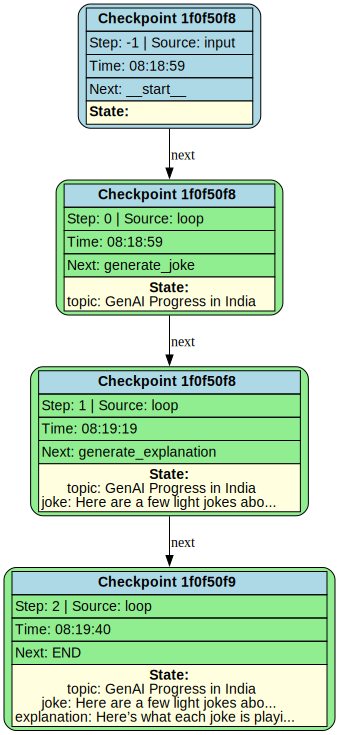

In [24]:
from checkpoint_visualizer import visualize_checkpoints, visualize_checkpoints_compact
visualize_checkpoints(chat_workflow, thread_id="1")

In [25]:
new_state = chat_workflow.update_state( { 
    "configurable" : {
        "thread_id" : "1",
        "checkpoint_id" : "1f0f4fe2-5bb1-6c4a-bfff-5929feb75a5b",
        "checkpoint_ns" : "" 
        } },
    {
    "topic" : "SarvamAI Contribution in India"
    })

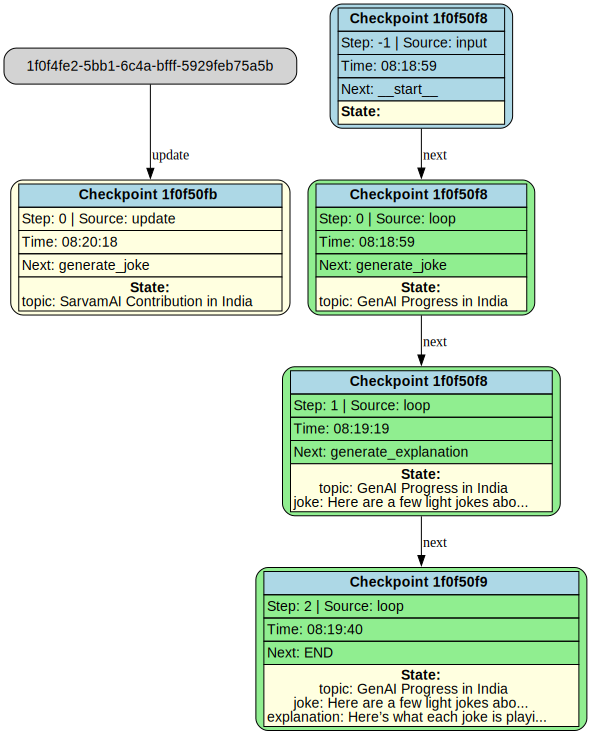

In [26]:
visualize_checkpoints(chat_workflow, thread_id="1")

In [27]:
new_state_history = list(chat_workflow.get_state_history(config_1))

In [28]:
rprint(new_state_history)

[
    StateSnapshot(
        values={'topic': 'SarvamAI Contribution in India'},
        next=('generate_joke',),
        config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50fb-0e3c-611a-8000-329524df1618'
            }
        },
        metadata={'source': 'update', 'step': 0, 'parents': {}},
        created_at='2026-01-19T08:20:18.951599+00:00',
        parent_config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f4fe2-5bb1-6c4a-bfff-5929feb75a5b'
            }
        },
        tasks=(
            PregelTask(
                id='5e42d063-e579-1e20-7f94-76218f539ffc',
                name='generate_joke',
                path=('__pregel_pull', 'generate_joke'),
                error=None,
                interrupts=(),
                state=None,
                result=None
            ),
        ),
        interrupts=()
    ),
    StateSnapshot(
        values={
            'topic': 'GenAI Progress in India',
            'joke': 'Here are a few light jokes about GenAI progress in India. Pick your favorite or I can tailor 
one:\n\n- GenAI progress in India is so fast that my phone’s AI wrote my resume, pitched it to investors, and 
booked me a job—all before I could finish saying, “I need a job.”\n\n- In India, GenAI is moving so quickly that 
the chaiwala’s app can predict your spice tolerance, suggest the perfect chutney, and route the delivery—all while 
you take a sip.\n\n- GenAI in India is progressing so fast that even the dabbawala network uses AI to optimize 
lunchbox routes—bells ring, lunch lands, and you get a Hinglish update before the rotis cool.',
            'explanation': 'Here’s what each joke is playing with, in plain terms:\n\n- Joke 1: “GenAI progress… my
phone’s AI wrote my resume, pitched it to investors, and booked me a job—all before I could finish saying, ‘I need 
a job.’”\n  - Why it’s funny: Exaggerates AI’s speed and autonomy. It starts with a relatable situation (job 
hunting) and flips it so AI does everything instantly, even making the pitch and securing a job before you can 
finish a simple sentence. It ascribes almost magical efficiency to GenAI in a bite-sized, self-referential 
moment.\n\n- Joke 2: “In India, GenAI is moving so quickly that the chaiwala’s app can predict your spice 
tolerance, suggest the perfect chutney, and route the delivery—all while you take a sip.”\n  - Why it’s funny: 
Mixes a beloved everyday figure (chaiwala) with cutting-edge tech. The humor comes from AI handling tiny, everyday 
preferences (spice level, chutney choice) and logistics (routing) in real time—so fast you barely finish your tea. 
It playfully elevates a humble street-side vendor into a high-tech entrepeneur.\n\n- Joke 3: “GenAI in India is 
progressing so fast that even the dabbawala network uses AI to optimize lunchbox routes—bells ring, lunch lands, 
and you get a Hinglish update before the rotis cool.”\n  - Why it’s funny: Combines legendary efficiency (dabbawala
lunchbox system) with modern AI optimization. The image of bells signaling punctual delivery plus an AI-generated 
Hinglish update creates a vivid, cultural contrast. The line about rotis cooling adds a dash of timing-comedy—AI is
so fast you’re getting updates before the food cools.\n\nIf you’d like, I can tailor one of these (or craft a fresh
variant) for a specific audience, city, or tone. Do you prefer a version focused on work life, food culture, or a 
broader tech satire vibe?'
        },
        next=(),
        config={
            'configurable': {
                'thread_id': '1',
                'checkpoint_ns': '',
                'checkpoint_id': '1f0f50f9-a0b2-6ccb-8002-65fb64aa679a'
            }
        },
        metadata={'source': 'loop', 'step': 2, 'parents': {}},
        created_at='2026-01-19T08:19:40.622340+00:00',
        par

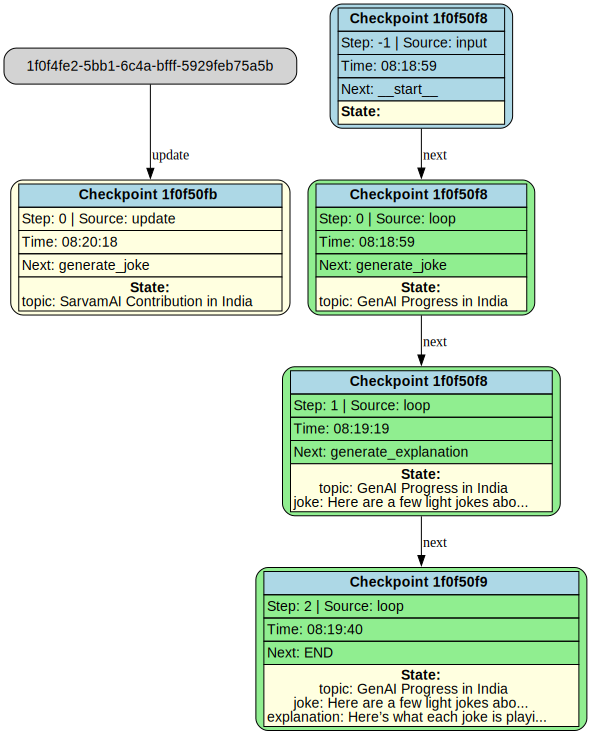

In [29]:
visualize_checkpoints(chat_workflow, thread_id="1")

In [31]:
new_state = chat_workflow.invoke(None,  { "configurable" : { "thread_id" : "1", "checkpoint_id" : "1f0f50a2-d63f-6daa-8000-f9ef02c9661d"}})

EmptyInputError: Received no input for __start__

In [32]:
rprint(new_state)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f50fb-0e3c-611a-8000-329524df1618'}}

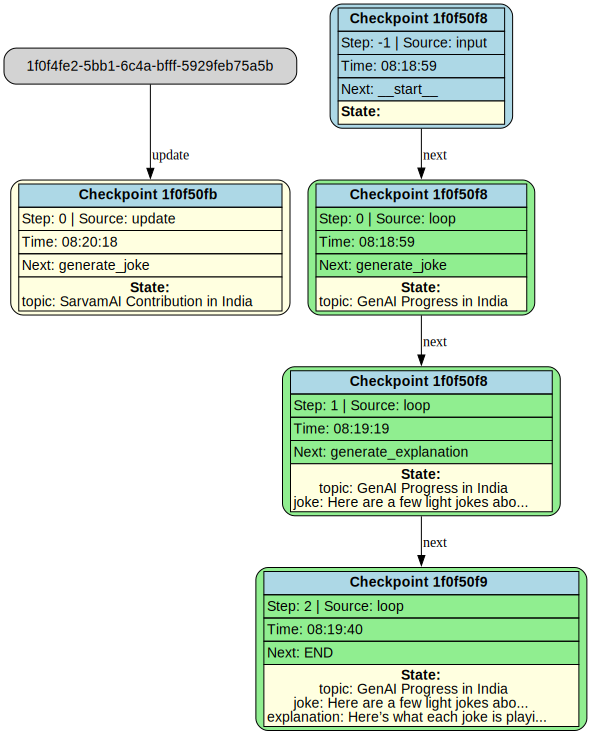

In [33]:
visualize_checkpoints(chat_workflow, thread_id="1")

## Fault Tolerance

In [34]:
import time

class CrashState(TypedDict):
    input1 : str
    step1 : str
    step2 : str

In [35]:
def step_1(state : CrashState):
    print("✅ Step 1 Executed")
    return { "step1" : "done", "input" : state["input1"] }

In [36]:
def step_2(state : CrashState):
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(100)
    print("✅ Step 2 Executed")
    return { "step2" : "done" }

In [37]:
def step_3(state : CrashState):
    print("✅ Step 3 Executed")
    return { "done" : True }

In [38]:
builder = StateGraph(CrashState)

builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer = checkpointer)

In [39]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input1": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")


▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 Executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
❌ Kernel manually interrupted (crash simulated).


In [ ]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)


🔁 Re-running the graph to demonstrate fault tolerance...
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)


In [ ]:
fault = list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

In [ ]:
fault

In [ ]:
visualize_checkpoints(fault, thread_id="thread-1")